In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Custom imports
from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_generator import DataGenerator

print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10491723122008075882
xla_global_id: -1
]
Tensorflow version: 2.7.0
Keras version: 2.7.0


### Open hdf5 file, load the labels and define training/validation splits ###

In [2]:
# Data folder and hdf5 dataset file
data_root = os.path.normpath('.')
#data_root = os.path.normpath('/media/sf_vbshare/physionet_data/')
#data_root = os.path.normpath('/home/ubuntu/projects/csproject')
# hd_file = os.path.join(data_root, 'physio.h5')
hd_file = "/scratch/thurasx/ecg_project_2/cnn_ecg_keras/physio.h5"
label_file = '/scratch/thurasx/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv')

# Open hdf5 file
h5file =  h5py.File(hd_file, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]

# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:/n', label_df.iloc[100:110,])

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


In [76]:
print(h5file)
print(len(partition['train']) + len(partition['validation']))
print(partition['validation'][0:10])
print({k: labels[k] for k in list(labels)[:10]})

<HDF5 file "physio.h5" (mode r)>
8528
['A00599', 'A02174', 'A04608', 'A01127', 'A00427', 'A03145', 'A05451', 'A05803', 'A06316', 'A00629']
{'A00001': 1, 'A00002': 1, 'A00003': 1, 'A00004': 0, 'A00005': 0, 'A00006': 1, 'A00007': 1, 'A00008': 2, 'A00009': 0, 'A00010': 1}


## data distribution

In [83]:
df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
df_stat = df.groupby('label').agg('count').reset_index()
df_stat.columns = ['label', 'recordings']
df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int8))
print(df_stat)
df_set = list(df.label.unique())

arr = np.array(df['label'])
print("Number of records: ", len(arr))
ind, count = np.unique(arr, return_counts=True)
print(f'Labels {ind}/nCounts {count}')


  label  recordings  percent
0     A         758        9
1     N        5076       60
2     O        2415       28
3     ~         279        3
Number of records:  8528
Labels ['A' 'N' 'O' '~']
Counts [ 758 5076 2415  279]


## Show random ECG data

In [ ]:

from physionet_processing import fetch_h5data
np.random.seed(148)

# Open large hdf5 file (download https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
h5file =  h5py.File(hd_file, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

def get_sample():
    # Pick one ECG randomly from each class 
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()

slen = 1500
idx_list = [dataset_list.index(name) for name in name_list]
data = fetch_h5data(h5file, idx_list, sequence_length = slen)
time = np.arange(0, slen)/300

fig, ax = plt.subplots(1, len(idx_list), figsize = (17, 3))

for i, ax1 in enumerate(ax):
    
    ax1.plot(time, data[i], color = 'r')
    ax1.set(xlim = [0, 5], xticks = np.arange(0, 5.5, 1),
            ylim = [-0.5, 1.2], yticks = np.arange(-0.5, 1.2, 0.5),
            xlabel = 'Time [s]', ylabel = 'Potential [mV]')
    ax1.set_title(name_list[i] + ' class:' + df_set[i])


plt.tight_layout()
plt.show()    
fig.savefig('physionet_classes.png', bbox_inches = 'tight', dpi = 150)

['A05203', 'A00216', 'A00428', 'A07070']
5202
[-0.022 -0.021 -0.02  ...  0.649  0.823  1.063]


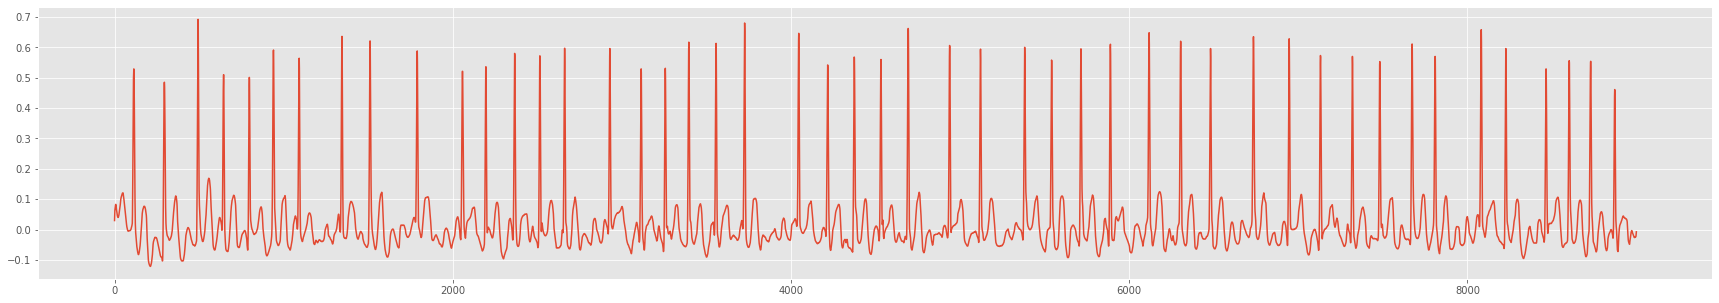

In [25]:
print(name_list)
print(dataset_list.index(name_list[0]))
print(h5file[dataset_list[dataset_list.index(name_list[0])]]['ecgdata'][:, 0])
plt.figure(figsize=(30,5))
plt.plot(h5file[dataset_list[dataset_list.index(name_list[1])]]['ecgdata'][:, 0])

Unique sampling rates in dataset: [300.0]
Unique gain settings in dataset: [1000.0]
Unique baseline settings: [0.0]
Sequence lengths [min, max]: [2714, 18286]
Recording times in seconds [min, max]: [9.047, 60.953]


/Users/macbookpro/Documents/mac_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


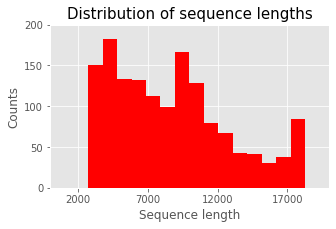

In [10]:
from physionet_processing import special_parameters
import seaborn as sns

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()
fig.savefig('physionet_sequenceLenHist.png', bbox_inches = 'tight', dpi = 150)

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] # universal sampling rate
sequence_length = sequence_length_max # will use the maximum sequence length

### Set up batch generators ###

In [67]:
# Parameters needed for the batch generator

# Maximum sequence length
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, idx_list, sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape
print(dim)
print(Sxx.shape)
print(len(data))
# print('Maximum sequence length:', max_length)

(570, 33)
(4, 570, 33)
4


(18286,)


/var/folders/0b/dyb338nj37b116mhm821bd700000gp/T/ipykernel_83627/1687202465.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(abs(data[0])), label = "Log ECG")


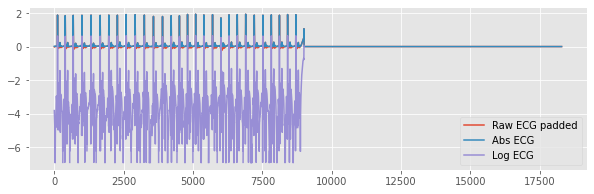

In [88]:
plt.figure(figsize=(10,3))
plt.plot(data[0], label="Raw ECG padded")
plt.plot(abs(data[0]), label="Abs ECG")
plt.plot(np.log(abs(data[0])), label = "Log ECG")
plt.legend()
print(data[0].shape)

In [68]:
params = {'batch_size': batch_size,
            'dim': dim,
            'nperseg': spectrogram_nperseg,
            'noverlap': spectrogram_noverlap,
            'n_channels': 1,
            'sequence_length': sequence_length,
            'n_classes': n_classes,
            'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


In [70]:
print(next(val_generator))

TypeError: 'DataGenerator' object is not an iterator

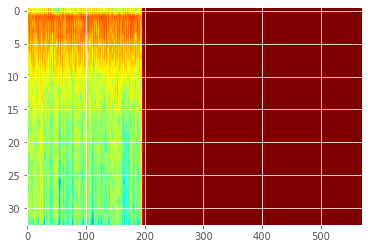

In [14]:
import matplotlib.pyplot as plt

plt.imshow(X[2,:,:,0].transpose(), cmap = 'jet', aspect = 'auto')
plt.show()

# print(len(X))

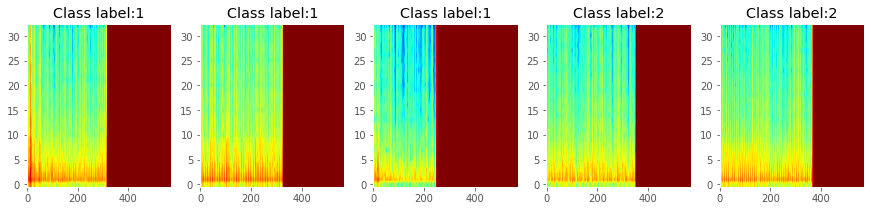

(32, 570, 33, 1)
[0. 1. 0. 0.]


In [82]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]
    #batch_labels = ['Class label:' + str(np.argmax(y[idx,])[0]) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (15, 3))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        #ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set(title = batch_labels[i])
    
    plt.show()
        
    return fig

batch_idx = [0, 1, 2, 3, 4]
fig = imshow_batch(X, y, batch_idx)
plt.show()
print(X.shape)
print(y[0])

### Define the model ###

In [79]:
# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

In [81]:
# Define the model
# Model parameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer

print("Data Input Shape : ", input_shape)
model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth



# Remove the frequency dimension, so that the output can feed into LSTM
# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.core.Masking(mask_value = 0.0))
model.add(MeanOverTime())

# Alternative: Replace averaging by LSTM

# Insert masking layer to ignore zeros
#model.add(layers.core.Masking(mask_value = 0.0))

# Add LSTM layer with 3 neurons
#model.add(layers.LSTM(200))
#model.add(layers.Flatten())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid', kernel_regularizer = regularizers.l2(0.1)))


model.summary()

Data Input Shape :  (570, 33, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 570, 33, 32)       320       
                                                                 
 batch_normalization_24 (Bat  (None, 570, 33, 32)      128       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 570, 33, 32)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 570, 33, 32)       9248      
                                                                 
 batch_normalization_25 (Bat  (None, 570, 33, 32)      128       
 chNormalization)                                                
                                                                 
 activation_25 (Activ

In [38]:
import datetime 
# Compile the model and run a batch through the network
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
h = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 50,
                              epochs = 3,
                              validation_data = val_generator,
                              validation_steps = 50, callbacks=[tensorboard_callback])

Epoch 1/3


/var/folders/0b/dyb338nj37b116mhm821bd700000gp/T/ipykernel_70174/4173455027.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(generator = train_generator,


50/50 [==============================] - 111s 2s/step - loss: 1.0383 - acc: 0.6000 - val_loss: 101088.7109 - val_acc: 0.5850
Epoch 2/3
50/50 [==============================] - 102s 2s/step - loss: 1.0195 - acc: 0.5944 - val_loss: 1144.8745 - val_acc: 0.2956
Epoch 3/3
50/50 [==============================] - 102s 2s/step - loss: 0.9707 - acc: 0.6288 - val_loss: 2.0907 - val_acc: 0.5888


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


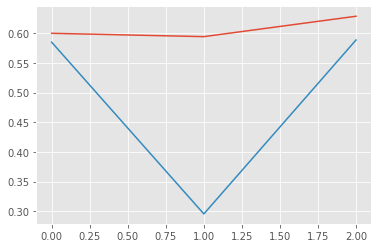

In [46]:
import matplotlib.pyplot as plt

print(h.history.keys())
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.show()

In [ ]:
model.save('/scratch/thurasx/ecg_project_2/cnn_ecg_keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/scratch/thurasx/ecg_project_2/cnn_ecg_keras/keras_ecg_cnn.tflite', 'wb+') as f:
  f.write(tflite_model)

In [3]:
df = pd.DataFrame(h.history)
df.head()
df.to_csv('/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/history.csv')

NameError: name 'h' is not defined

In [2]:
def smoothcols(df, cols):
    
    lfrac = 0.02
    lowess = sm.nonparametric.lowess
    df_sm = df.copy()
    x = df.epoch.values

    # Replace columns with smoothed values
    for c in cols:
        df_sm[c]  = lowess(df[c].values, x, frac = lfrac)[:,1]
        
    return df_sm

In [3]:
import statsmodels.api as sm
def smoothcols(df, cols):
    
    lfrac = 0.02
    lowess = sm.nonparametric.lowess
    df_sm = df.copy()
    x = df.epoch.values

    # Replace columns with smoothed values
    for c in cols:
        df_sm[c]  = lowess(df[c].values, x, frac = lfrac)[:,1]
        
    return df_sm

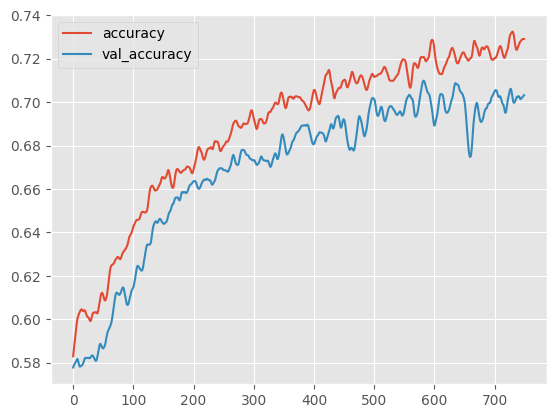

In [9]:
h = pd.read_csv("/Users/sanda/Documents/esp_dev_files/ecg_project_2/cnn_ecg_keras/history_small_2.csv")

cols_to_sm = list(h.columns)[0:] # columns for smoothing
df_sm = smoothcols(h, cols_to_sm)

plt.plot(df_sm.acc, label='accuracy')
plt.plot(df_sm.val_acc, label='val_accuracy')
plt.legend()
plt.show()

In [5]:
h = pd.read_csv("/Users/sanda/Documents/esp_dev_files/ecg_project_2/cnn_ecg_keras/history_small_3.csv")

cols_to_sm = list(h.columns)[0:] # columns for smoothing
df_sm = smoothcols(h, cols_to_sm)

plt.plot(df_sm.acc, label='accuracy')
plt.plot(df_sm.val_acc, label='val_accuracy')
plt.legend()
plt.show()

ValueError: Length of values (268) does not match length of index (2000)

In [ ]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 570, 33, 1)
      yield [data.astype(np.float32)]


# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations= [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

with open('/Users/sanda/Documents/esp_dev_files/cnn_ecg_keras/keras_ecg_cnn_quan.tflite', 'wb+') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\sanda\AppData\Local\Temp\tmp2n5fnc9w\assets


In [ ]:
print("size of no quan: ", os.path.getsize("keras_ecg_cnn.tflite"))
print("size of quan: ", os.path.getsize("keras_ecg_cnn_quan.tflite"))

size of no quan:  14190744
size of quan:  3641928


In [ ]:
# %tensorboard --logdir logs/fit/20221027-144438

UsageError: Line magic function `%tensorboard` not found.
